In [6]:
import random
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from PIL import Image
from tqdm import tqdm
from torchvision.transforms import ToTensor
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ———————————
# 1) K 계산 및 초기화 함수 (변경 없음)
# ———————————

def compute_optimal_k(patches, min_k=100, max_k=150, sil_window=5, random_state=42):
    """
    patches: numpy array of shape (N, C, psize, psize), 이미 L2 정규화된 상태여도 무방
    """
    N = patches.shape[0]
    max_k_adj = min(max_k, N - 1)
    min_k_adj = min(min_k, max_k_adj)
    if max_k_adj < 2:
        return 1
    ks = list(range(min_k_adj, max_k_adj + 1))
    flat = patches.reshape(N, -1)

    # 1) inertia 계산
    inertias = [
        KMeans(n_clusters=k, random_state=random_state).fit(flat).inertia_
        for k in ks
    ]
    # 2) knee 지점 찾기
    kl = KneeLocator(ks, inertias, curve="convex", direction="decreasing")
    k_knee = kl.knee or ks[np.argmax(np.diff(inertias))]

    # 3) knee 주변에서 silhouette 점수 비교
    lo = max(min_k_adj, k_knee - sil_window)
    hi = min(max_k_adj, k_knee + sil_window)
    best_k, best_score = k_knee, -1
    for k in tqdm(range(lo, hi + 1), desc="Silhouette search"):
        labels = KMeans(n_clusters=k, random_state=random_state).fit_predict(flat)
        score = silhouette_score(flat, labels)
        if score > best_score:
            best_score, best_k = score, k

    return best_k

def init_filters(patches, k, psize=9):
    """
    patches: numpy array of shape (N, C, psize, psize), 이미 정규화된 상태여도 무방
    """
    N, C, _, _ = patches.shape
    flat = patches.reshape(N, -1)
    centers = KMeans(n_clusters=k, random_state=42).fit(flat).cluster_centers_
    # (k, C*psize*psize) → (k, C, psize, psize)
    return centers.reshape(k, C, psize, psize)


def compute_entropy(patch, bins=8):
    gray = np.squeeze(patch)
    h, _ = np.histogram(gray, bins=bins, range=(0, 1), density=True)
    h = h + 1e-10
    h = h / h.sum()
    return -np.sum(h * np.log2(h))

regions = lambda H, W: {
    'lt': (slice(0, H // 2), slice(0, W // 2)),
    'rt': (slice(0, H // 2), slice(W // 2, W)),
    'lb': (slice(H // 2, H), slice(0, W // 2)),
    'rb': (slice(H // 2, H), slice(W // 2, W)),
    'ct': (slice(H // 4, 3 * H // 4), slice(W // 4, 3 * W // 4))
}

def extract_patches(ds, percent=0.05, psize=9):
    """
    ds: torchvision dataset (예: EMNIST, MNIST 등), transform에 SobelGrayTransform 포함되어 있음.
    percent: 클래스별 전체 샘플 중 몇 %를 patch로 뽑을지
    psize: 패치 크기 (정사각형)
    ---
    반환값: numpy array of shape (num_patches, 1, psize, psize)
    """
    targets = np.array(ds.targets)
    patches = []
    for cls in np.unique(targets):
        idxs = np.where(targets == cls)[0]
        n = max(1, int(len(idxs) * percent))
        for i in random.sample(list(idxs), n):
            img, _ = ds[i]              # SobelGrayTransform이 적용되어 (1,H,W) tensor 반환
            arr = img.numpy()           # (1, H, W)
            C, H, W = arr.shape
            for rs, cs in regions(H, W).values():
                block = arr[:, rs, cs]  # (1, h, w)
                h, w = block.shape[1:]
                best_en, best_p = None, None
                for y in range(h - psize + 1):
                    for x in range(w - psize + 1):
                        p = block[:, y:y + psize, x:x + psize]
                        pn = (p - p.min()) / (p.max() - p.min() + 1e-10)
                        en = compute_entropy(pn)
                        if best_en is None or en > best_en:
                            best_en, best_p = en, pn
                if best_p is not None:
                    patches.append(best_p)
    patches = np.stack(patches, 0)  # (총_패치_개수, 1, psize, psize)
    print(f"Extracted {patches.shape[0]} patches (pct={percent})")
    return patches

# ———————————
# 3) filter_precompute.py (실행 부분)
# ———————————

# ——— 설정 ———
dataset_name = 'emnist'    # 'cifar10', 'mnist', 'emnist'
patch_pct = 0.05
patch_size = 9

import numpy as np
import cv2
import torch
nm = {'mean':[0.1307],'std':[0.3081]}
# ——— 전처리 파이프라인 (순서 중요!) ———
tf = transforms.Compose([
    ToTensor(),            # PIL.Image → Tensor([1, H, W]) ∈ [0,1]
    transforms.Normalize(nm['mean'], nm['std'])
])

# ——— 데이터셋 로드 ———
if dataset_name == 'cifar10':
    ds = datasets.CIFAR10('./data', train=True, transform=tf, download=True)
elif dataset_name == 'mnist':
    ds = datasets.MNIST('./data', train=True, transform=tf, download=True)
else:
    ds = datasets.EMNIST('./data', split='balanced', train=True, transform=tf, download=True)

# 1) 패치 추출
patches = extract_patches(ds, percent=patch_pct, psize=patch_size)
#    patches.shape == (N, 1, patch_size, patch_size)

# ———————————
# 4) **여기서 L2 기반 Prune & Normalize 수행** 
# ———————————

# 4-1) 모든 패치(flatten)에서 L2 노름 계산
N = patches.shape[0]
flat_patches = patches.reshape(N, -1)                  # (N, patch_size*patch_size)
norms = np.linalg.norm(flat_patches, axis=1)           # (N,)

# 4-2) threshold 정의 (예: 전체 패치 중 최대 노름의 50% 미만은 제거)
threshold = 0.3 * norms.max()
mask = norms > threshold                              # True: 남길 패치, False: 제거할 패치
pruned_patches = patches[mask]                         # (N', 1, patch_size, patch_size)
num_removed = N - pruned_patches.shape[0]
print(f"Removed {num_removed} patches. Remaining {pruned_patches.shape[0]} patches.")

# 4-3) 남은 패치를 각자 L2 노름으로 나눠서 정규화
pruned_flat = pruned_patches.reshape(pruned_patches.shape[0], -1)       # (N', D)
pruned_norms = np.linalg.norm(pruned_flat, axis=1, keepdims=True)       # (N', 1)
normalized_patches = (pruned_flat / (pruned_norms + 1e-8)).reshape(pruned_patches.shape)
# normalized_patches.shape == (N', 1, patch_size, patch_size)
print("Pruned & normalized patches ready.")

# ———————————
# 5) KMeans 수행 (정제된 패치로)
# ———————————

# 5-1) 최적 K 찾기
opt_k = compute_optimal_k(normalized_patches, min_k=290, max_k=310)
print(f"Calculated optimal k = {opt_k}")

# 5-2) KMeans 클러스터 센터(필터) 초기화 (normalized 상태에서 clustering)
filters = init_filters(normalized_patches, k=opt_k, psize=patch_size)
print("KMeans done – filters shape:", filters.shape)  # (opt_k, 1, patch_size, patch_size)

# ———————————
# 6) 결과 저장 (파일명에 dataset, pct, k 포함)
# ———————————

out_fname = f'filters_{dataset_name}_pct{int(patch_pct*100)}_k{opt_k}_{patch_size}_wosobel.npy'
np.save(out_fname, filters)
print(f"Saved {filters.shape[0]} filters to {out_fname}")



Extracted 28200 patches (pct=0.05)
Removed 1593 patches. Remaining 26607 patches.
Pruned & normalized patches ready.


Silhouette search: 100%|██████████| 7/7 [02:03<00:00, 17.70s/it]


Calculated optimal k = 293
KMeans done – filters shape: (293, 1, 9, 9)
Saved 293 filters to filters_emnist_pct5_k293_9_wosobel.npy


Loaded filters shape: (150, 1, 9, 9)


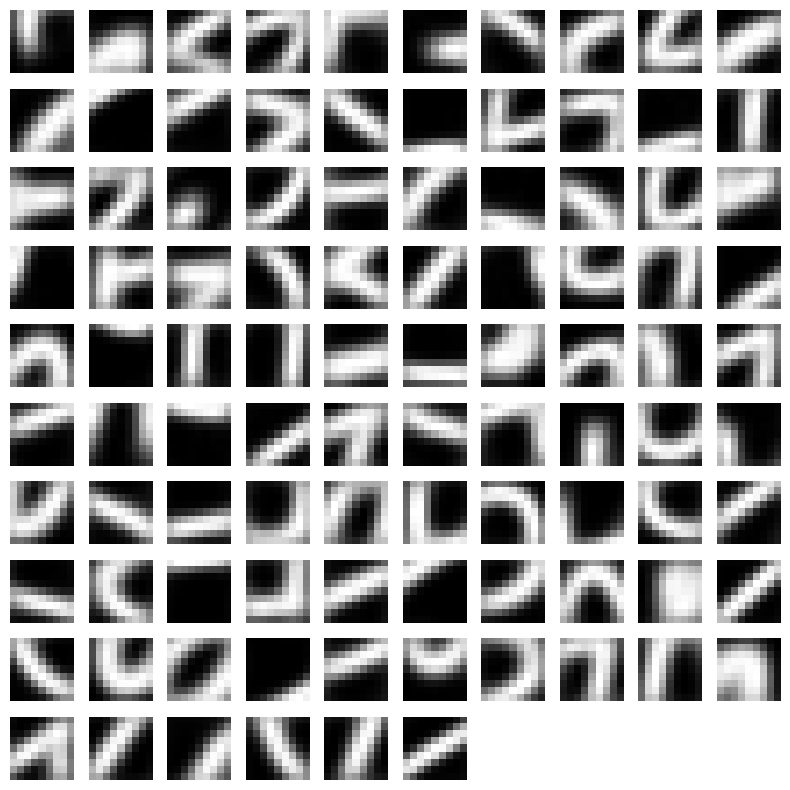

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_filters(npy_path: str) -> np.ndarray:
    """
    npy 파일에서 (k, C, H, W) 형태의 필터 텐서를 로드
    """
    npy_path = Path(npy_path)
    if not npy_path.is_file():
        raise FileNotFoundError(f"{npy_path} not found")
    return np.load(npy_path)

def visualize_filters(filters: np.ndarray, n: int = 150):
    """
    첫 n개의 필터를 정사각 격자(grid)로 시각화
    - Gray‑scale 필터(C=1)은 cmap='gray'
    - RGB 필터(C=3)는 채널 축을 (H,W,C)로 전환 후 그대로 표시
    """
    k, C, H, W = filters.shape
    n = min(n, k)
    g = int(np.ceil(np.sqrt(n)))          # grid 크기 (g × g)

    fig, axes = plt.subplots(g, g, figsize=(8, 8))
    for idx in range(g * g):
        ax = axes[idx // g, idx % g]
        ax.axis("off")

        if idx < n:
            f = filters[idx]

            # 시각화를 위해 0–1 범위로 개별 정규화
            f_norm = (f - f.min()) / (f.max() - f.min() + 1e-8)

            if C == 1:                # Gray‑scale
                ax.imshow(f_norm[0], cmap="gray")
            else:                     # 다채널(RGB 등)
                ax.imshow(np.transpose(f_norm, (1, 2, 0)))

    plt.tight_layout()
    plt.show()

# ============ 사용 예시 ============ #
# (경로를 여러분이 저장한 npy 파일명으로 바꿔주세요)
npy_file = "filters_emnist_pct5_k150_9_wosobel.npy"

filters  = load_filters(npy_file)
print(f"Loaded filters shape: {filters.shape}")  # 예: (123, 1, 9, 9)
visualize_filters(filters, n=96)


Loaded filters shape: (96, 1, 9, 9)


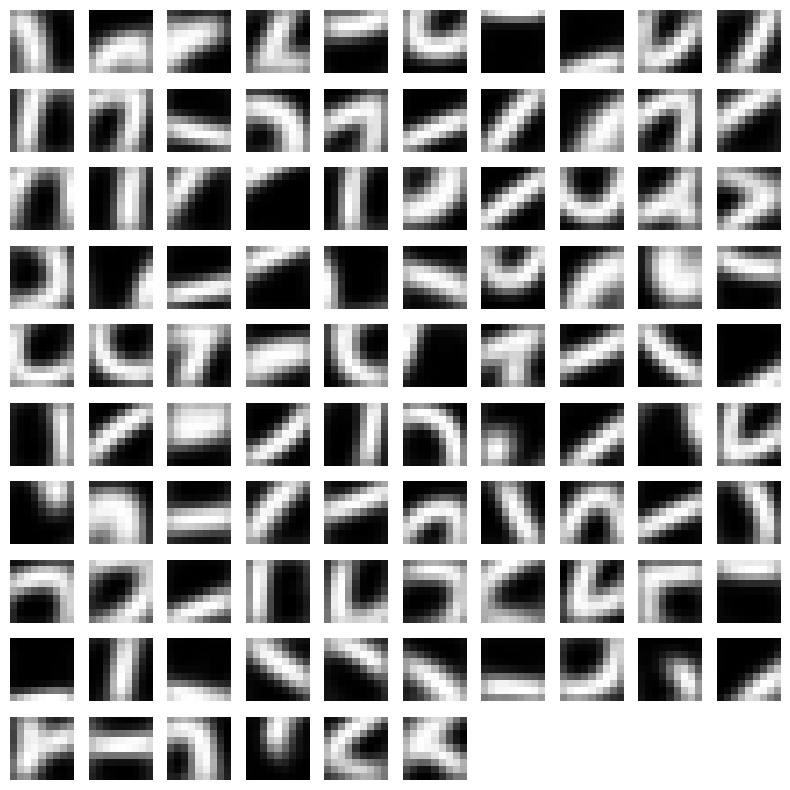

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_filters(npy_path: str) -> np.ndarray:
    """
    npy 파일에서 (k, C, H, W) 형태의 필터 텐서를 로드
    """
    npy_path = Path(npy_path)
    if not npy_path.is_file():
        raise FileNotFoundError(f"{npy_path} not found")
    return np.load(npy_path)

def visualize_filters(filters: np.ndarray, n: int = 150):
    """
    첫 n개의 필터를 정사각 격자(grid)로 시각화
    - Gray‑scale 필터(C=1)은 cmap='gray'
    - RGB 필터(C=3)는 채널 축을 (H,W,C)로 전환 후 그대로 표시
    """
    k, C, H, W = filters.shape
    n = min(n, k)
    g = int(np.ceil(np.sqrt(n)))          # grid 크기 (g × g)

    fig, axes = plt.subplots(g, g, figsize=(8, 8))
    for idx in range(g * g):
        ax = axes[idx // g, idx % g]
        ax.axis("off")

        if idx < n:
            f = filters[idx]

            # 시각화를 위해 0–1 범위로 개별 정규화
            f_norm = (f - f.min()) / (f.max() - f.min() + 1e-8)

            if C == 1:                # Gray‑scale
                ax.imshow(f_norm[0], cmap="gray")
            else:                     # 다채널(RGB 등)
                ax.imshow(np.transpose(f_norm, (1, 2, 0)))

    plt.tight_layout()
    plt.show()

# ============ 사용 예시 ============ #
# (경로를 여러분이 저장한 npy 파일명으로 바꿔주세요)
npy_file = "filters_emnist_pct5_k96_9_wosobel.npy"

filters  = load_filters(npy_file)
print(f"Loaded filters shape: {filters.shape}")  # 예: (123, 1, 9, 9)
visualize_filters(filters, n=96)


In [ ]:
# ———————————
# 5-3) 필터 상관 행렬 계산 · 시각화 · 중복 제거
# ———————————
import matplotlib.pyplot as plt

def prune_correlated_filters_cc(filters, corr_thr=0.9, abs_corr=True, mode='mean'):
    """
    mode:
      'mean'  – 성분 안에서 평균 |corr| 이 가장 큰 필터 보존
      'degree'– corr>thr 인 에지 개수가 가장 많은 필터 보존
      'norm'  – L2-norm 이 가장 큰 필터 보존
    """
    k = filters.shape[0]
    flat = filters.reshape(k, -1)
    flat = flat - flat.mean(1, keepdims=True)
    corr = np.corrcoef(flat)
    if abs_corr:
        corr_val = np.abs(corr)
    else:
        corr_val = corr

    # 1) adjacency (대각 제외)
    adj = (corr_val > corr_thr) & (~np.eye(k, dtype=bool))

    # 2) 연결 성분 탐색 (DFS/Union-Find 등)
    visited = np.zeros(k, dtype=bool)
    keep = np.zeros(k, dtype=bool)
    for v in range(k):
        if visited[v]:
            continue
        # --- 한 성분 모으기 ---
        stack, comp = [v], []
        while stack:
            u = stack.pop()
            if visited[u]:
                continue
            visited[u] = True
            comp.append(u)
            nbrs = np.where(adj[u])[0]
            stack.extend(nbrs)

        # comp 안에서 대표 선택
        if len(comp) == 1:
            keep[comp[0]] = True
            continue

        if mode == 'mean':
            m = corr_val[np.ix_(comp, comp)].mean(1)   # 각 행(필터)의 평균 corr
            rep = comp[np.argmax(m)]
        elif mode == 'degree':
            deg = adj[comp][:, comp].sum(1)            # corr>thr 에지 개수
            rep = comp[np.argmax(deg)]
        else:  # 'norm'
            norms = np.linalg.norm(flat[comp], axis=1)
            rep = comp[np.argmax(norms)]

        keep[rep] = True   # 하나만 남김

    pruned = filters[keep]
    return pruned, corr_val

# ― 1) prune + corr 계산
corr_threshold = 0.8          # 원하는 값으로 조정
pruned_filters, corr_mat = prune_correlated_filters_cc(
    filters,
    corr_thr=0.8,
    abs_corr=True,
    mode='mean'   # 또는 'degree' / 'norm' 실험해보세요
)
print(f"{filters.shape[0]} -> {pruned_filters.shape[0]} after CC pruning")


# ― 2) corr 행렬 시각화
plt.figure(figsize=(6, 5))
plt.imshow(np.abs(corr_mat), vmin=0, vmax=1, aspect='auto')
plt.title(f'|Correlation| matrix ({filters.shape[0]}×{filters.shape[0]})')
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

